In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.maps as maps

In [2]:
dbFile = 'baseline_v1.4_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
bundleList = []
filtername = 'r'
nside = 64
sql = 'filter="%s"' % filtername
mapsList = [maps.TrilegalDensityMap(filtername=filtername, nside=nside)]
metric = metrics.NstarsMetric(filtername=filtername, crowding_error=0.1, metricName='Crowding_0.1', maps=[])
slicer = slicers.HealpixSlicer(nside=nside)
summaryStats = [metrics.SumMetric()]
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats, mapsList=mapsList))

metric = metrics.NstarsMetric(filtername=filtername, crowding_error=0.2, metricName='Crowding_0.2', maps=[])
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats, mapsList=mapsList))

metric = metrics.NstarsMetric(filtername=filtername, crowding_error=0.2, ignore_crowding=True, metricName='No_Crowding_0.2', maps=[])
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats, mapsList=mapsList))

metric = metrics.NstarsMetric(filtername=filtername, crowding_error=0.1, ignore_crowding=True, metricName='No_Crowding_0.1', maps=[])
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats, mapsList=mapsList))

bg = metricBundles.MetricBundleGroup(bundleList, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="r" for columns ['seeingFwhmGeom', 'fieldDec', 'fieldRA', 'fiveSigmaDepth']
Found 474955 visits
Running:  ['opsim_Crowding_0_1_r_HEAL', 'opsim_Crowding_0_2_r_HEAL', 'opsim_No_Crowding_0_2_r_HEAL', 'opsim_No_Crowding_0_1_r_HEAL']


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "filter="r"" constraint now.
monopole: 40480.1  dipole: lon: -140.482, lat: -44.9966, amp: 34890.5
monopole: 87645.1  dipole: lon: -119.839, lat: -36.6392, amp: 108741


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 5501 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 229834  dipole: lon: -99.758, lat: -23.0163, amp: 394394


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 5539 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 184667  dipole: lon: -99.8213, lat: -22.7138, amp: 315628
Plotting complete.


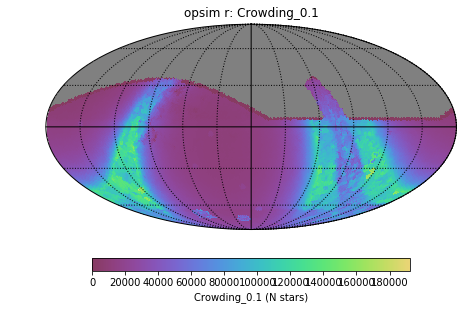

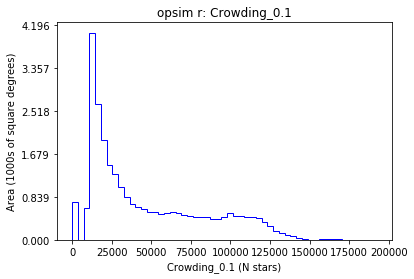

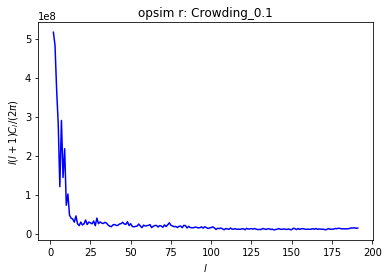

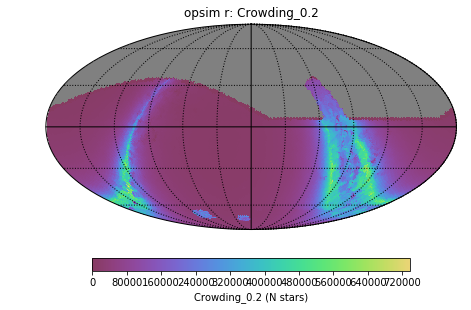

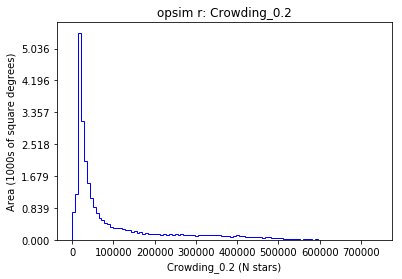

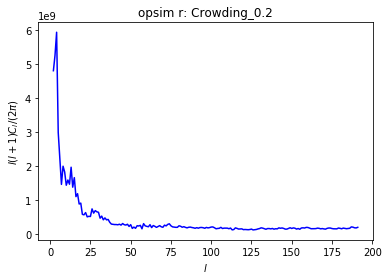

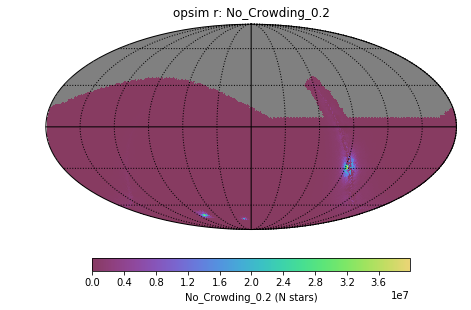

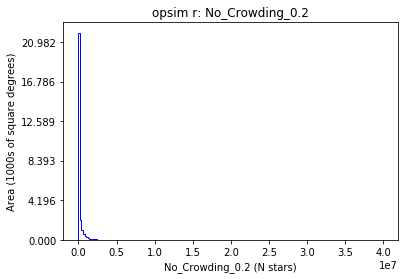

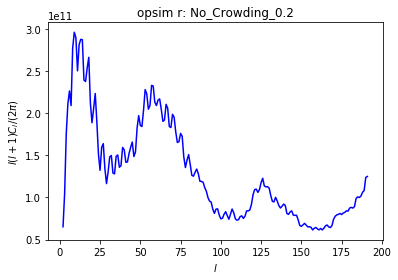

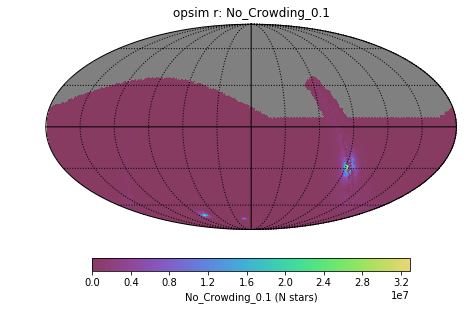

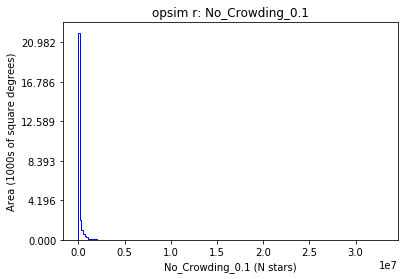

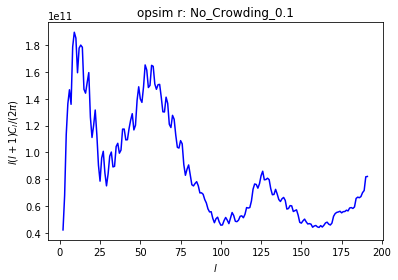

In [4]:
bg.plotAll(closefigs=False)

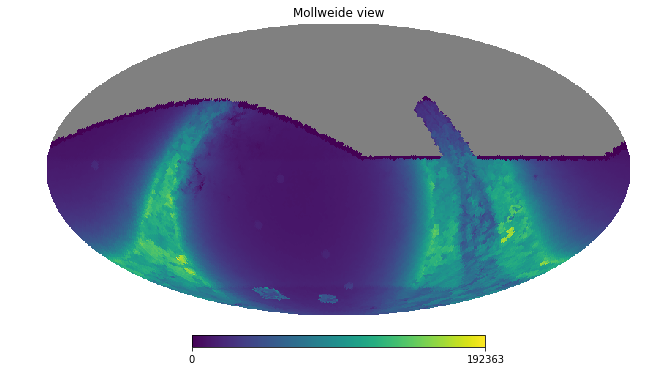

In [5]:
hp.mollview(bundleList[0].metricValues)

In [6]:
for b in bundleList:
    print(b.metric.name, b.summaryValues['Sum']/1e9)

Crowding_0.1 1.535511714263488
Crowding_0.2 3.343253675104168
No_Crowding_0.2 8.219936218060724
No_Crowding_0.1 6.584479855959162


In [7]:
data = np.load('/Users/yoachim/git_repos/sims_maps/TriMaps/TRIstarDensity_%s_nside_64.npz' % filtername)
# Cumulative number counts, units of stars/sq deg. Array at healpix locations
starDensity = data['starDensity'].copy()
# magnitude bins 
bins=data['bins'].copy()
# pixels where there were so many stars some were skipped
mask = data['overMaxMask']

In [8]:
starDensity.shape, bins.shape

((49152, 65), (66,))

In [9]:
mid_bin = (bins[1:]+bins[0:-1])/2.

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


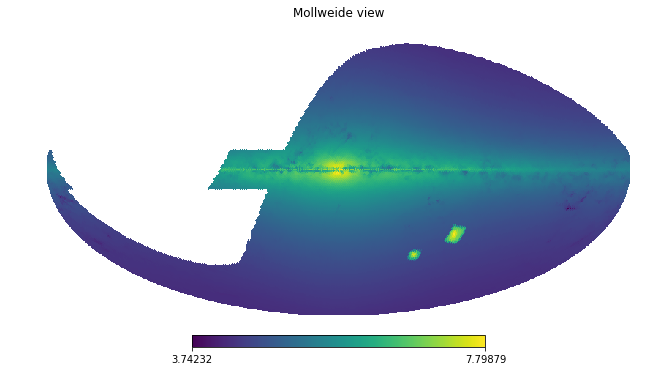

In [10]:
hp.mollview(np.log10(starDensity[:,-1]), nest=True)

In [11]:
area = hp.nside2pixarea(nside, degrees=True)
tot = np.sum(starDensity[:,-1])*area

In [12]:
tot/1e9

11.415928974999998

(24, 28)

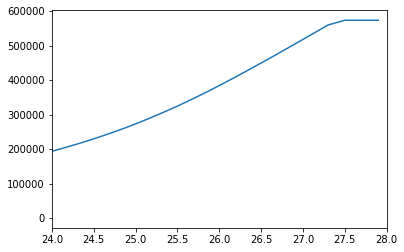

In [13]:
plt.plot(mid_bin, starDensity[100, :])
plt.xlim([24,28])